#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями


In [1]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_target(data, title_str, stat=True):
    if stat:
        DF_ct = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ct')
        DF_ctt = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ctt')
        print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}') 
        
    (title, name_1) = title_str
    plt.figure(figsize =(20, 4))
    plt.plot( data.index, data[TARGET_NAME], 'b' )
    plt.title(title, size=14)
    plt.xlabel('Время')
    plt.ylabel(name_1)
    plt.show()

In [3]:
file_name = 'my_BRENT2019.csv'
data = pd.read_csv(file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(2667, 11)


Значение  year  month  dayofmonth  quarter  dayofyear  weekofyear  \
Дата                                                                            
2010-09-01     76.37  2010      9           1        3        244          35   
2010-09-02     76.89  2010      9           2        3        245          35   

            dayofweek  is_holiday  is_prev_holiday  is_next_holiday  
Дата                                                                 
2010-09-01          2           0                0                0  
2010-09-02          3           0                0                0

In [4]:
TARGET_NAME = 'Значение'

In [5]:
data.loc[1:, 'diff_1'] = data[TARGET_NAME][:-1].values - data[TARGET_NAME][1:].values
data.head(2)

Значение  year  month  dayofmonth  quarter  dayofyear  weekofyear  \
Дата                                                                            
2010-09-01     76.37  2010      9           1        3        244          35   
2010-09-02     76.89  2010      9           2        3        245          35   

            dayofweek  is_holiday  is_prev_holiday  is_next_holiday  diff_1  
Дата                                                                         
2010-09-01          2           0                0                0     NaN  
2010-09-02          3           0                0                0   -0.52

#### 2. сделайте ее перрасчет (ресемплинг) в представление по неделям

Augmented Dickey–Fuller тест: 0.331, 0.32


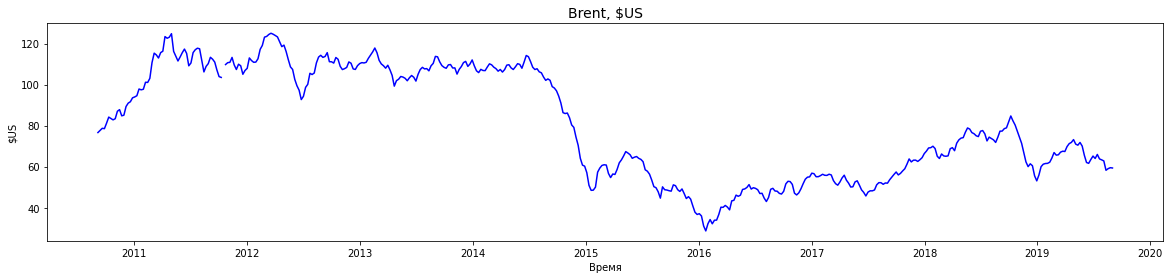

In [6]:
data_w = data.resample('W').mean()
data_w.head(2)
title_str = 'Brent, $US', '$US'
plot_target(data_w, title_str)

In [7]:
data_w = data_w.drop(['dayofmonth', 'dayofweek', 'dayofyear', 'is_holiday', 'is_prev_holiday','is_next_holiday'], axis = 1)
data_w.head()

Значение    year     month   quarter  weekofyear    diff_1
Дата                                                                   
2010-09-05  76.616000  2010.0  9.000000  3.000000        35.0 -0.065000
2010-09-12  77.673333  2010.0  9.000000  3.000000        36.0 -0.288333
2010-09-19  78.693333  2010.0  9.000000  3.000000        37.0  0.021667
2010-09-26  78.518333  2010.0  9.000000  3.000000        38.0 -0.118333
2010-10-03  81.211667  2010.0  9.333333  3.333333        39.0 -0.791667

In [8]:
data_w.isna().sum()

Значение      1
year          1
month         1
quarter       1
weekofyear    1
diff_1        1
dtype: int64

In [9]:
data_w.iloc[57:60,:]

Значение    year  month  quarter  weekofyear    diff_1
Дата                                                                
2011-10-09  103.476667  2011.0   10.0      4.0        40.0 -0.455000
2011-10-16         NaN     NaN    NaN      NaN         NaN       NaN
2011-10-23  109.756667  2011.0   10.0      4.0        42.0 -1.806667

In [10]:
data_w.iloc[58,:] = (data_w.iloc[57,:] + data_w.iloc[59,:])/2


Augmented Dickey–Fuller тест: 0.433, 0.403


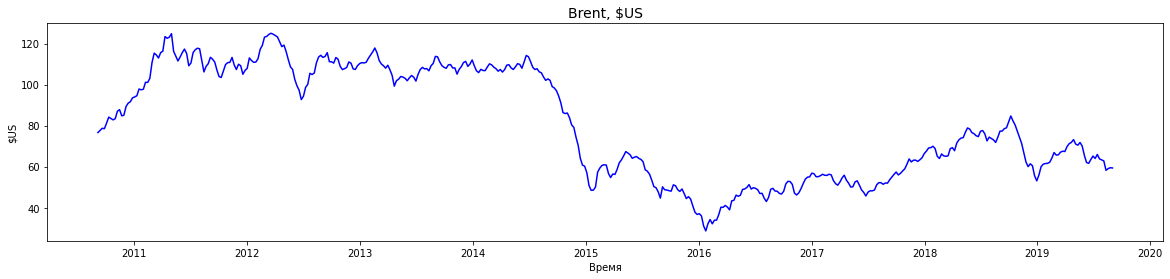

In [11]:
data_w.iloc[57:60,:]
title_str = 'Brent, $US', '$US'
plot_target(data_w, title_str)

#### 3. Добавьте первые разности по стоимости доллара и евро к рублю.


In [12]:
usd=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx',index_col=[1], parse_dates=[1])
usd.drop(['nominal','cdx'], axis=1,inplace = True)
usd.head()

curs
data               
2010-09-01  30.8669
2010-09-02  30.8001
2010-09-03  30.6858
2010-09-04  30.6922
2010-09-07  30.5771

In [13]:
usd_w = usd.copy().resample('W').mean()
usd_w.head()

curs
data                
2010-09-05  30.76125
2010-09-12  30.79402
2010-09-19  30.84672
2010-09-26  30.99920
2010-10-03  30.52764

In [14]:
usd_w.isna().sum()

curs    8
dtype: int64

Augmented Dickey–Fuller тест: 0.291, 0.387


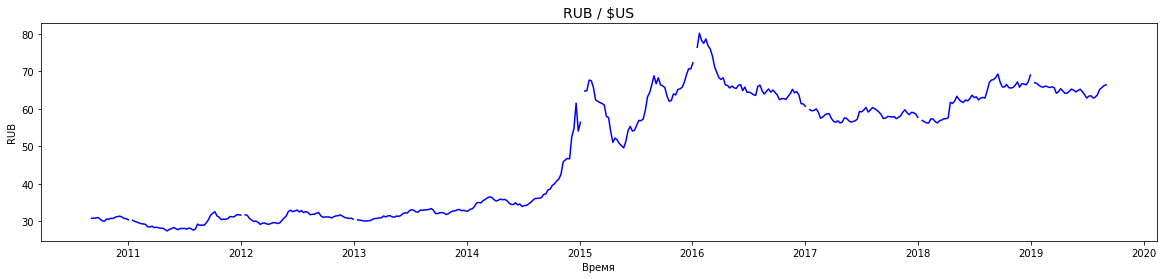

In [15]:
TARGET_NAME = 'curs'
title_str = 'RUB / $US', 'RUB'
plot_target(usd_w, title_str)

In [16]:
print(np.where(usd_w.isna()))

(array([ 18,  70, 122, 227, 279, 331, 383, 435], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


фактически торги в первую неделю не проходили и действовал курс на конец года, поэтому заменим пропуски предыдущим значением


In [17]:
for usd in [ 18,  70, 122, 227, 279, 331, 383, 435]:
    usd_w.iloc[usd,:] = usd_w.iloc[usd-1,:]

Augmented Dickey–Fuller тест: 0.274, 0.398


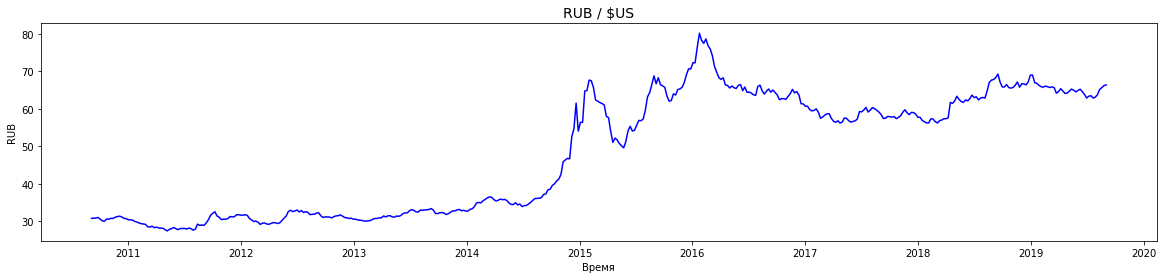

In [18]:
plot_target(usd_w, title_str)

In [19]:
usd_w.loc[1:, 'usd_diff_1'] = usd_w[TARGET_NAME][:-1].values - usd_w[TARGET_NAME][1:].values
usd_w.head(2)

curs  usd_diff_1
data                            
2010-09-05  30.76125         NaN
2010-09-12  30.79402    -0.03277

In [20]:
usd_w['usd_diff_1'].fillna(0, inplace=True)


In [21]:
eur=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx',index_col=[1], parse_dates=[1])
eur.drop(['nominal','cdx'], axis=1,inplace = True)
eur.head()

curs
data               
2010-09-01  39.0127
2010-09-02  39.1654
2010-09-03  39.2901
2010-09-04  39.3505
2010-09-07  39.4720

In [22]:
eur_w = eur.copy().resample('W').mean()
eur_w.head()

curs
data                 
2010-09-05  39.204675
2010-09-12  39.293360
2010-09-19  39.977740
2010-09-26  41.042640
2010-10-03  41.351660

In [23]:
eur_w.isna().sum()
print(np.where(eur_w.isna()))

(array([ 18,  70, 122, 227, 279, 331, 383, 435], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


In [24]:
for eur in [ 18,  70, 122, 227, 279, 331, 383, 435]:
    eur_w.iloc[eur,:] = eur_w.iloc[eur-1,:]

Augmented Dickey–Fuller тест: 0.149, 0.249


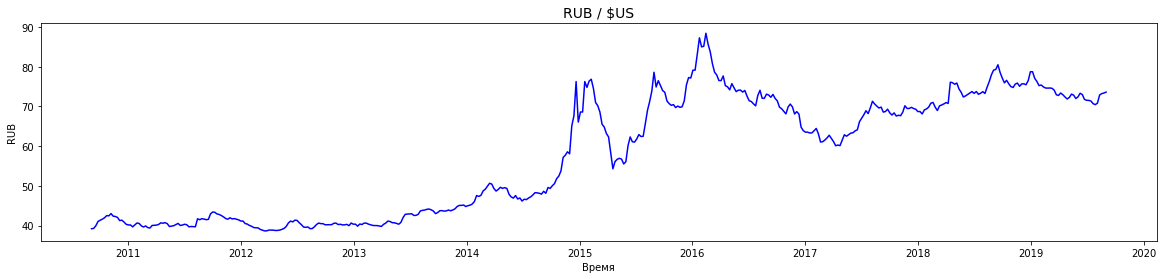

In [25]:
plot_target(eur_w, title_str)

In [26]:
eur_w.loc[1:, 'eur_diff_1'] = eur_w[TARGET_NAME][:-1].values - eur_w[TARGET_NAME][1:].values
eur_w.head(2)


curs  eur_diff_1
data                             
2010-09-05  39.204675         NaN
2010-09-12  39.293360   -0.088685

In [27]:
eur_w['eur_diff_1'].fillna(0, inplace=True)


In [28]:
data_w = pd.concat([data_w, usd_w.usd_diff_1, eur_w.eur_diff_1], axis=1)
TARGET_NAME = 'Значение'
data_w.head(2)

Значение    year  month  quarter  weekofyear    diff_1  \
Дата                                                                  
2010-09-05  76.616000  2010.0    9.0      3.0        35.0 -0.065000   
2010-09-12  77.673333  2010.0    9.0      3.0        36.0 -0.288333   

            usd_diff_1  eur_diff_1  
Дата                                
2010-09-05     0.00000    0.000000  
2010-09-12    -0.03277   -0.088685

#### 4. Постройте модель предсказания 1-й точки от текущей (h=1).


In [29]:
t = 100

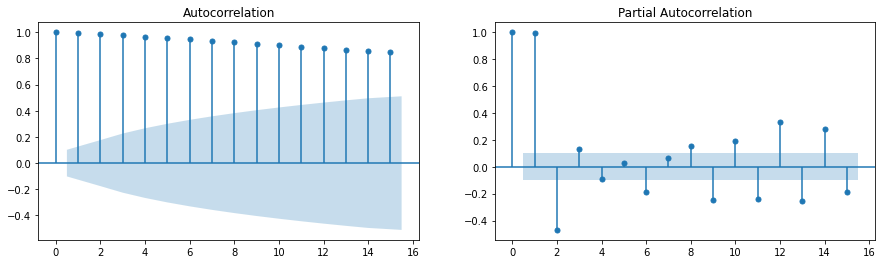

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 15

sm.graphics.tsa.plot_acf(data_w[TARGET_NAME].values[t:], lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_w[TARGET_NAME].values[t:], lags=lag, ax=axes[1])
plt.show()

In [31]:
data_w.loc[1:, 'diff_1'] = data_w[TARGET_NAME][:-1].values - data_w[TARGET_NAME][1:].values
data_w.loc[2:, 'diff_2'] = data_w[TARGET_NAME][:-2].values - data_w[TARGET_NAME][2:].values
data_w = data_w.fillna(0)
data_w.head(2)

Значение    year  month  quarter  weekofyear    diff_1  \
Дата                                                                  
2010-09-05  76.616000  2010.0    9.0      3.0        35.0 -0.065000   
2010-09-12  77.673333  2010.0    9.0      3.0        36.0 -1.057333   

            usd_diff_1  eur_diff_1  diff_2  
Дата                                        
2010-09-05     0.00000    0.000000     0.0  
2010-09-12    -0.03277   -0.088685     0.0

In [32]:
INDEPENDENT_VARIABLE_NAMES = data_w.columns[1:]


In [33]:
def train_test_split(data, split_date, h=1):
    ind = data.index
    
    X = data.loc[ind[:-h], INDEPENDENT_VARIABLE_NAMES]    
    y = data.loc[ind[h:], TARGET_NAME]    
    
    df = X
    df.loc[:, TARGET_NAME] = y.values
    
    df_train = df[df.index.get_level_values('Дата') < split_date]
    df_test = df[df.index.get_level_values('Дата') >= split_date]    
    
    return df_train, df_test

In [34]:
split_date = '2018-02-02'
df_train, df_test = train_test_split(data_w, split_date)

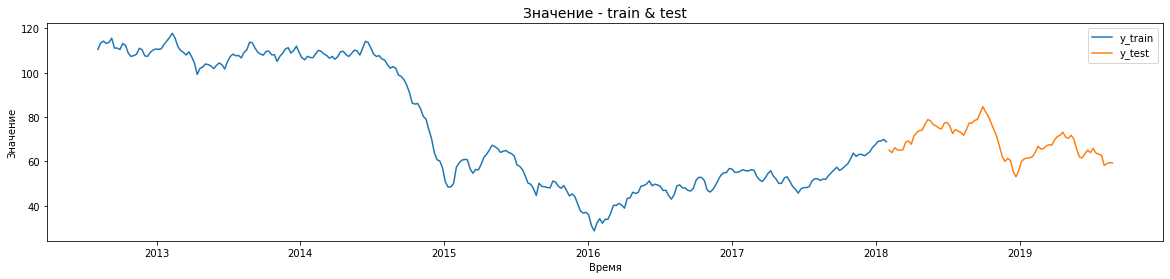

In [35]:
plt.figure( figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel(TARGET_NAME)
plt.plot(df_train.index[t:], df_train[TARGET_NAME][t:], label='y_train' )
plt.plot(df_test.index, df_test[TARGET_NAME], label='y_test')
plt.title(f'{TARGET_NAME} - train & test', size=14)
plt.legend()
plt.show()

In [36]:
def select_variables(X, y, k_best=5, percentile=10):
    cols = X.columns
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    y = scaler.fit_transform(np.array(y).reshape(-1, 1))       
    
    f_test, _ = f_regression(X, y)
    f_test /= np.max(f_test)

    # KBest
    sfk = SelectKBest(f_regression, k=k_best)
    sfk.fit_transform(X, y)    
    set_1 = list(cols[sfk.get_support()])

    # Percentile
    sfp = SelectPercentile(f_regression, percentile=percentile)
    sfp.fit_transform(X, y)    
    set_2 = list(cols[sfp.get_support()])

    # Model
    model_gb = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)
    model_gb.fit(X, y.ravel())

    sfm = SelectFromModel(model_gb,  max_features=k_best)
    sfm.fit(X, y.ravel())
    sfm.transform(X)    
    set_3 = list(cols[sfm.get_support()])

    
    return list(set(set_1 + set_2 + set_3))

In [37]:
SELECTED_VARIABLE_NAMES = select_variables(df_train[INDEPENDENT_VARIABLE_NAMES], df_train[TARGET_NAME])
SELECTED_VARIABLE_NAMES

['diff_1', 'weekofyear', 'diff_2', 'month', 'year']

In [38]:
SELECTED_VARIABLE_NAMES += ['usd_diff_1', 'eur_diff_1']

In [39]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
def plot_predictions(y, y_pred):
    plt.figure( figsize=(15, 4))

    plt.xlabel('Время')
    plt.ylabel('$US')
    plt.plot(df_test.index, y_pred, label='прогноз' )
    plt.plot(df_test.index, y, label='факт')
    plt.title('Brent, $US', size=14)

    plt.legend()
    plt.show()

In [41]:
def plot_corr_with_lag(y, y_pred, lag=5):
    corr_list = [np.corrcoef(y, y_pred)[1,0]]

    for i in range(lag):
        corr = np.corrcoef(y[:-(i+1)], y_pred[(i+1):])[1,0]
        corr_list.append(corr)    

    plt.figure(figsize=(8, 4))
    plt.plot(corr_list)
    plt.xlabel('Лаг корреляции')
    plt.ylabel('Коэффициенты корреляции')
    plt.title('Корреляция цели и предсказаний с лагом просмотра', size=14)
    plt.show()

In [42]:
SELECTED_VARIABLE_NAMES

['diff_1', 'weekofyear', 'diff_2', 'month', 'year', 'usd_diff_1', 'eur_diff_1']

mse:	77.263
mae:	6.998
R2:	-0.584
mape:	9.687%


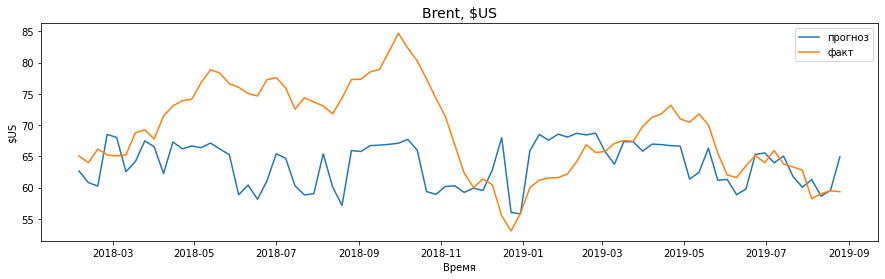

In [43]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)
model_gb.fit(df_train[SELECTED_VARIABLE_NAMES], df_train[TARGET_NAME])

y_pred = model_gb.predict(df_test[SELECTED_VARIABLE_NAMES])

y = df_test[TARGET_NAME]
mse = mean_squared_error(y, y_pred) 
mae = mean_absolute_error(y, y_pred) 
R2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'mse:\t{round(mse, 3)}\nmae:\t{round(mae, 3)}\nR2:\t{round(R2, 3)}\nmape:\t{round(mape, 3)}%')

plot_predictions(y, y_pred)

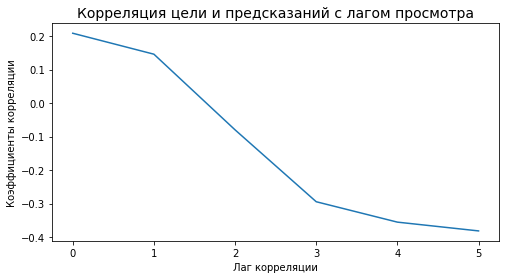

In [44]:
y = df_test[TARGET_NAME].values
plot_corr_with_lag(y, y_pred)

In [45]:
def recalculate_df_test(ind): 
    df_test_rolling = df_test.loc[ind, [TARGET_NAME] + SELECTED_VARIABLE_NAMES] 

    for i in range(len(ind)):
        if i == 1:
            value = df_test_rolling.loc[ind[i - 1], TARGET_NAME] - df_test.loc[df_test.index[t0 - 1], TARGET_NAME] 
            df_test_rolling.loc[ind[i], 'diff_1'] = value            
            value = df_test_rolling.loc[ind[i - 1], TARGET_NAME] - df_test.loc[df_test.index[t0 - 2], TARGET_NAME]
            df_test_rolling.loc[ind[i], 'diff_2'] = value

        y_pred = model_gb.predict(pd.DataFrame(df_test_rolling.loc[ind[i], SELECTED_VARIABLE_NAMES]).T)[0]
        df_test_rolling.loc[ind[i], TARGET_NAME] = y_pred

    df_test_rolling = df_test_rolling.loc[ind[1]:, :]
    
    return df_test_rolling

In [46]:
predictions_horizon = 1
n_samples = 30
starting_points = random.sample(range(2, len(y_pred) - predictions_horizon - 1), n_samples)

results = []
for t0 in starting_points:    
    ind = df_test.index[t0 : t0 + predictions_horizon + 1]
    df_test_rolling = recalculate_df_test(ind)
    
    prediction = df_test_rolling.loc[ind[predictions_horizon], TARGET_NAME]
    actual = df_test.loc[ind[predictions_horizon], TARGET_NAME]
    
    result = abs((actual - prediction) / actual * 100)              
    results.append(result)
    
mape = np.array(results).mean()
print(f'mape = {round(mape, 3)}%')

mape = 8.639%


#### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [ ]:
Ошибка предсказания ряда дает результат лучше на 1%